<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Monte-Carlo-simulation" data-toc-modified-id="Monte-Carlo-simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Monte Carlo simulation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Python" data-toc-modified-id="Python-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Python</a></span></li><li><span><a href="#NumPy" data-toc-modified-id="NumPy-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>NumPy</a></span></li><li><span><a href="#Numba" data-toc-modified-id="Numba-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Numba</a></span></li><li><span><a href="#Cython-—-Sequential" data-toc-modified-id="Cython-—-Sequential-3.0.4"><span class="toc-item-num">3.0.4&nbsp;&nbsp;</span>Cython — Sequential</a></span></li><li><span><a href="#Multiprocessing" data-toc-modified-id="Multiprocessing-3.0.5"><span class="toc-item-num">3.0.5&nbsp;&nbsp;</span>Multiprocessing</a></span></li></ul></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Requirements</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Monte Carlo simulation of the geometric Brownian motion

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import random
import numpy as np
import numba
import math
import matplotlib.pyplot as plt
import multiprocessing as mp

# Monte Carlo simulation
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- This section analyzes the **Monte Carlo** simulation of the geometric Brownian motion, a simple yet still widely used stochastic process to model the evolution of stock prices or index levels. 

- MCS is among the most important numerical techniques in finance, if not the most important and widely used. This mainly stems from the fact that it is the most flexible numerical method when it comes to the evaluation of mathematical expressions (e.g., integrals), and specifically the valuation of financial derivatives. The flexibility comes at the cost of a relatively high computational burden, though, since often hundreds of thousands or even millions of complex computations have to be carried out to come up with a single value estimate.
    
- Among others, the **Black-Scholes-Merton** (1973) theory of option pricing draws on this process. In their setup the underlying of the option to be valued follows the stochastic differential equation (SDE),

</font>
</div>

### Python

In [2]:
# Initial value of the risky asset.
S0 = 36.
# Time horizon for the binomial tree simulation.
T = 1.0
# Constant short rate.
r = 0.06
# Constant volatility factor.
sigma = 0.2

In [3]:
# The number of time intervals for discretization
M = 100  
# The number of paths to be simulated.
I = 50000  

In [4]:
def mcs_simulation_py(p):
    M, I = p
    T=1
    # Length of the time intervals.
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape)  
    for t in range(1, M + 1):  
        for i in range(I):  
            S[t, i] = S[t-1, i] * math.exp((r - sigma ** 2 / 2) * dt +
                                         sigma * math.sqrt(dt) * rn[t, i])  
    return S      

In [5]:
%time S = mcs_simulation_py((M, I))

CPU times: user 6.44 s, sys: 55.6 ms, total: 6.5 s
Wall time: 6.52 s


In [6]:
S[-1].mean()  

38.237147224118964

In [7]:
S0 * math.exp(r * T)  

38.22611567563295

In [8]:
K = 40.  

In [9]:
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()  

In [10]:
C0

3.8434973873653484

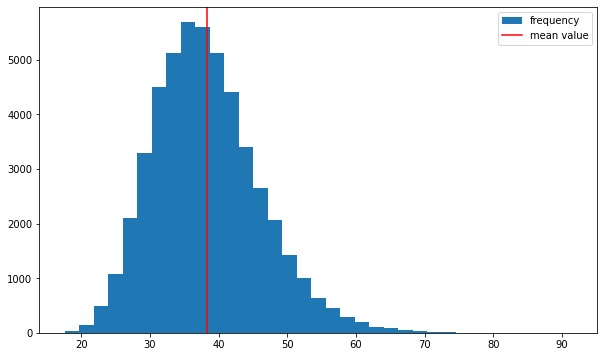

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=35, label='frequency')
plt.axvline(S[-1].mean(), color='r', label='mean value')
plt.legend(loc=0)

### NumPy

In [12]:
def mcs_simulation_np(p):
    M, I = p
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape)
    for t in range(1, M + 1):  
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt +
                               sigma * math.sqrt(dt) * rn[t]) 
    return S      

In [13]:
%time S = mcs_simulation_np((M, I))

CPU times: user 240 ms, sys: 18.8 ms, total: 259 ms
Wall time: 257 ms


In [14]:
S[-1].mean()

38.221235662460906

In [15]:
%timeit S = mcs_simulation_np((M, I))

236 ms ± 786 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba 

In [16]:
mcs_simulation_nb = numba.jit(mcs_simulation_py)

In [17]:
%time S = mcs_simulation_nb((M, I))  

CPU times: user 1.68 s, sys: 129 ms, total: 1.81 s
Wall time: 1.29 s


In [18]:
%time S = mcs_simulation_nb((M, I))  

CPU times: user 216 ms, sys: 7.97 ms, total: 224 ms
Wall time: 224 ms


In [19]:
S[-1].mean()

38.197830067938895

In [20]:
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()

In [21]:
C0

3.862846368078608

In [22]:
%timeit S = mcs_simulation_nb((M, I))  

220 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cython &mdash; Sequential

In [23]:
%load_ext Cython

In [24]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0 = 36.
cdef float T = 1.0
cdef float r = 0.06
cdef float sigma = 0.2
@cython.boundscheck(False)
@cython.wraparound(False)
def mcs_simulation_cy(p):
    cdef int M, I
    M, I = p
    cdef int t, i
    cdef float dt = T / M
    cdef double[:, :] S = np.zeros((M + 1, I))
    cdef double[:, :] rn = np.random.standard_normal((M + 1, I))
    S[0] = S0
    for t in range(1, M + 1):
        for i in range(I):
            S[t, i] = S[t-1, i] * exp((r - sigma ** 2 / 2) * dt +
                                         sigma * sqrt(dt) * rn[t, i])
    return np.array(S) 

In file included from /Users/gm_main/.cache/ipython/cython/_cython_magic_3bade390abf7e69ef40381b0d4cf2e55.c:769:
In file included from /opt/anaconda3/envs/ML4T/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /opt/anaconda3/envs/ML4T/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/anaconda3/envs/ML4T/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/opt/anaconda3/envs/ML4T/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.


In [25]:
%time S = mcs_simulation_cy((M, I))

CPU times: user 266 ms, sys: 39.7 ms, total: 306 ms
Wall time: 304 ms


In [26]:
S[-1].mean()

38.190437376383905

In [27]:
%timeit S = mcs_simulation_cy((M, I))

244 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Multiprocessing

In [28]:
pool = mp.Pool(processes=-1)  

In [29]:
p = 20  

In [30]:
%timeit S = np.hstack(pool.map(mcs_simulation_np, p * [(M, int(I / p))]))

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ML4T/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/ML4T/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/ML4T/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/ML4T/lib/python3.10/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'mcs_simulation_np' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ML4T/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/ML4T/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/ML4T

KeyboardInterrupt: 

In [ ]:
%timeit S = np.hstack(pool.map(mcs_simulation_nb, p * [(M, int(I / p))]))

In [ ]:
%timeit S = np.hstack(pool.map(mcs_simulation_cy, p * [(M, int(I / p))]))

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://github.com/yhilpisch/py4fi2nd/blob/master/code/ch10/10_performance_python.ipynb
- https://llvm.org/
- https://github.com/yhilpisch/py4fi2nd/blob/master/code/ch12/12_stochastics.ipynb
- Hilpisch, Yves. Python for finance: mastering data-driven finance. O'Reilly Media, 2018.

</font>
</div>

# Requirements
<hr style = "border:2px solid black" ></hr>

In [1]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

autopep8: 1.7.0
json    : 2.0.9
numpy   : 1.21.6

